In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
import tensorflow
# https://github.com/tensorflow/tensorflow/issues/46038
config = tensorflow.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = tensorflow.compat.v1.Session(config=config)

In [4]:
# machinelearningmastery.com/how-to-develop-an-information-maximizing-generative-adversarial-network-infogan-in-keras/

# example of training an infogan on mnist
from numpy import zeros
from numpy import ones
from numpy import expand_dims
from numpy import hstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.layers import Activation

# define the standalone discriminator model
def define_discriminator(n_cat, in_shape=(28,28,1)):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=in_shape)
    # downsample to 14x14
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
    d = LeakyReLU(alpha=0.1)(d)
    # downsample to 7x7
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = LeakyReLU(alpha=0.1)(d)
    d = BatchNormalization()(d)
    # normal
    d = Conv2D(256, (4,4), padding='same', kernel_initializer=init)(d)
    d = LeakyReLU(alpha=0.1)(d)
    d = BatchNormalization()(d)
    # flatten feature maps
    d = Flatten()(d)
    # real/fake output
    out_classifier = Dense(1, activation='sigmoid')(d)
    # define d model
    d_model = Model(in_image, out_classifier)
    # compile d model
    d_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
    # create q model layers
    q = Dense(128)(d)
    q = BatchNormalization()(q)
    q = LeakyReLU(alpha=0.1)(q)
    # q model output
    out_codes = Dense(n_cat, activation='softmax')(q)
    # define q model
    q_model = Model(in_image, out_codes)
    return d_model, q_model

# define the standalone generator model
def define_generator(gen_input_size):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image generator input
    in_lat = Input(shape=(gen_input_size,))
    # foundation for 7x7 image
    n_nodes = 512 * 7 * 7
    gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
    gen = Activation('relu')(gen)
    gen = BatchNormalization()(gen)
    gen = Reshape((7, 7, 512))(gen)
    # normal
    gen = Conv2D(128, (4,4), padding='same', kernel_initializer=init)(gen)
    gen = Activation('relu')(gen)
    gen = BatchNormalization()(gen)
    # upsample to 14x14
    gen = Conv2DTranspose(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    gen = Activation('relu')(gen)
    gen = BatchNormalization()(gen)
    # upsample to 28x28
    gen = Conv2DTranspose(1, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    # tanh output
    out_layer = Activation('tanh')(gen)
    # define model
    model = Model(in_lat, out_layer)
    return model

# define the combined discriminator, generator and q network model
def define_gan(g_model, d_model, q_model):
    # make weights in the discriminator (some shared with the q model) as not trainable
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    # connect g outputs to d inputs
    d_output = d_model(g_model.output)
    # connect g outputs to q inputs
    q_output = q_model(g_model.output)
    # define composite model
    model = Model(g_model.input, [d_output, q_output])
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'categorical_crossentropy'], optimizer=opt)
    return model

# load images
def load_real_samples():
    # load dataset
    (trainX, _), (_, _) = load_data()
    # expand to 3d, e.g. add channels
    X = expand_dims(trainX, axis=-1)
    # convert from ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    print(X.shape)
    return X

# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # select images and labels
    X = dataset[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_cat, n_samples):
    # generate points in the latent space
    z_latent = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_latent = z_latent.reshape(n_samples, latent_dim)
    # generate categorical codes
    cat_codes = randint(0, n_cat, n_samples)
    # one hot encode
    cat_codes = to_categorical(cat_codes, num_classes=n_cat)
    # concatenate latent points and control codes
    z_input = hstack((z_latent, cat_codes))
    return [z_input, cat_codes]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_cat, n_samples):
    # generate points in latent space and control codes
    z_input, _ = generate_latent_points(latent_dim, n_cat, n_samples)
    # predict outputs
    images = generator.predict(z_input)
    # create class labels
    y = zeros((n_samples, 1))
    return images, y

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_cat, n_epochs=10, n_batch=64):
    # calculate the number of batches per training epoch
    bat_per_epo = int(dataset.shape[0] / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # calculate the size of half a batch of samples
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_steps):
        # get randomly selected 'real' samples
        X_real, y_real = generate_real_samples(dataset, half_batch)
        # update discriminator and q model weights
        d_loss1 = d_model.train_on_batch(X_real, y_real)
        # generate 'fake' examples
        X_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_cat, half_batch)
        # update discriminator model weights
        d_loss2 = d_model.train_on_batch(X_fake, y_fake)
        # prepare points in latent space as input for the generator
        z_input, cat_codes = generate_latent_points(latent_dim, n_cat, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the g via the d and q error
        _,g_1,g_2 = gan_model.train_on_batch(z_input, [y_gan, cat_codes])
        # summarize loss on this batch
        print('>%d/%d, d[%.3f,%.3f], g[%.3f] q[%.3f]' % (i+1, n_steps, d_loss1, d_loss2, g_1, g_2))

# number of values for the categorical control code
n_cat = 10
# size of the latent space
latent_dim = 62
# create the discriminator
d_model, q_model = define_discriminator(n_cat)
# create the generator
gen_input_size = latent_dim + n_cat
g_model = define_generator(gen_input_size)
# create the gan
gan_model = define_gan(g_model, d_model, q_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim, n_cat)

(60000, 28, 28, 1)
>1, d[0.371,0.793], g[0.471] q[2.811]
>2, d[0.000,0.655], g[0.441] q[2.748]
>3, d[0.000,0.529], g[0.549] q[2.637]
>4, d[0.000,0.407], g[0.471] q[2.586]
>5, d[0.000,0.258], g[0.599] q[2.469]
>6, d[0.000,0.134], g[0.673] q[2.609]
>7, d[0.000,0.062], g[0.671] q[2.403]
>8, d[0.000,0.038], g[0.645] q[2.426]
>9, d[0.000,0.023], g[0.581] q[2.474]
>10, d[0.000,0.018], g[0.538] q[2.327]
>11, d[0.000,0.012], g[0.411] q[2.339]
>12, d[0.001,0.011], g[0.355] q[2.349]
>13, d[0.000,0.009], g[0.279] q[2.441]
>14, d[0.000,0.008], g[0.262] q[2.288]
>15, d[0.000,0.006], g[0.245] q[2.115]
>16, d[0.000,0.006], g[0.215] q[1.992]
>17, d[0.000,0.005], g[0.215] q[2.087]
>18, d[0.000,0.004], g[0.203] q[2.000]
>19, d[0.000,0.004], g[0.188] q[1.945]
>20, d[0.000,0.004], g[0.149] q[1.785]
>21, d[0.000,0.003], g[0.179] q[1.671]
>22, d[0.000,0.003], g[0.205] q[1.682]
>23, d[0.000,0.003], g[0.228] q[1.559]
>24, d[0.000,0.002], g[0.134] q[1.596]
>25, d[0.001,0.002], g[0.143] q[1.658]
>26, d[0.000,0.

>210, d[0.000,0.000], g[0.003] q[0.028]
>211, d[0.000,0.000], g[0.003] q[0.027]
>212, d[0.000,0.000], g[0.002] q[0.021]
>213, d[0.000,0.000], g[0.003] q[0.033]
>214, d[0.000,0.000], g[0.002] q[0.017]
>215, d[0.000,0.000], g[0.003] q[0.023]
>216, d[0.000,0.000], g[0.003] q[0.017]
>217, d[0.000,0.000], g[0.002] q[0.024]
>218, d[0.000,0.000], g[0.003] q[0.021]
>219, d[0.000,0.000], g[0.002] q[0.023]
>220, d[0.000,0.000], g[0.002] q[0.014]
>221, d[0.000,0.000], g[0.003] q[0.018]
>222, d[0.000,0.000], g[0.002] q[0.017]
>223, d[0.000,0.000], g[0.001] q[0.019]
>224, d[0.000,0.000], g[0.002] q[0.026]
>225, d[0.000,0.000], g[0.002] q[0.020]
>226, d[0.000,0.000], g[0.003] q[0.019]
>227, d[0.000,0.000], g[0.002] q[0.024]
>228, d[0.000,0.000], g[0.002] q[0.021]
>229, d[0.000,0.000], g[0.003] q[0.015]
>230, d[0.000,0.000], g[0.002] q[0.020]
>231, d[0.000,0.000], g[0.002] q[0.017]
>232, d[0.000,0.000], g[0.002] q[0.022]
>233, d[0.000,0.000], g[0.001] q[0.032]
>234, d[0.000,0.000], g[0.001] q[0.020]


>417, d[0.000,0.000], g[0.012] q[0.010]
>418, d[0.000,0.000], g[0.008] q[0.010]
>419, d[0.000,0.000], g[0.015] q[0.010]
>420, d[0.000,0.000], g[0.015] q[0.011]
>421, d[0.000,0.000], g[0.012] q[0.007]
>422, d[0.000,0.000], g[0.012] q[0.009]
>423, d[0.000,0.000], g[0.009] q[0.009]
>424, d[0.000,0.000], g[0.010] q[0.008]
>425, d[0.000,0.000], g[0.008] q[0.008]
>426, d[0.000,0.000], g[0.008] q[0.013]
>427, d[0.000,0.000], g[0.008] q[0.010]
>428, d[0.000,0.000], g[0.012] q[0.010]
>429, d[0.000,0.000], g[0.018] q[0.010]
>430, d[0.000,0.000], g[0.021] q[0.009]
>431, d[0.000,0.000], g[0.016] q[0.008]
>432, d[0.000,0.000], g[0.011] q[0.010]
>433, d[0.000,0.000], g[0.010] q[0.011]
>434, d[0.000,0.000], g[0.009] q[0.008]
>435, d[0.000,0.000], g[0.008] q[0.015]
>436, d[0.000,0.000], g[0.015] q[0.010]
>437, d[0.000,0.000], g[0.011] q[0.007]
>438, d[0.000,0.000], g[0.012] q[0.008]
>439, d[0.000,0.000], g[0.008] q[0.012]
>440, d[0.000,0.000], g[0.012] q[0.009]
>441, d[0.000,0.000], g[0.011] q[0.011]


>623, d[0.001,0.253], g[5.550] q[0.740]
>624, d[0.036,0.210], g[4.982] q[0.571]
>625, d[0.220,1.274], g[4.969] q[0.571]
>626, d[0.610,0.337], g[4.968] q[0.366]
>627, d[0.132,0.069], g[4.919] q[0.535]
>628, d[0.200,0.297], g[4.138] q[0.327]
>629, d[0.083,0.258], g[4.752] q[0.437]
>630, d[0.102,0.133], g[5.282] q[0.337]
>631, d[0.346,0.221], g[3.129] q[0.374]
>632, d[0.051,0.153], g[3.645] q[0.540]
>633, d[0.022,0.071], g[4.694] q[0.260]
>634, d[0.048,0.026], g[3.673] q[0.260]
>635, d[0.083,0.151], g[3.729] q[0.347]
>636, d[0.027,0.070], g[4.359] q[0.287]
>637, d[0.059,0.030], g[4.012] q[0.295]
>638, d[0.050,0.166], g[4.303] q[0.277]
>639, d[0.044,0.133], g[5.167] q[0.184]
>640, d[0.070,0.036], g[4.841] q[0.268]
>641, d[0.058,0.116], g[4.753] q[0.157]
>642, d[0.070,0.033], g[4.492] q[0.305]
>643, d[0.036,0.134], g[4.959] q[0.224]
>644, d[0.089,0.037], g[4.531] q[0.237]
>645, d[0.029,0.018], g[3.534] q[0.166]
>646, d[0.036,0.234], g[5.080] q[0.232]
>647, d[0.151,0.039], g[4.033] q[0.289]


>828, d[0.162,0.104], g[2.753] q[0.060]
>829, d[0.092,0.187], g[3.769] q[0.181]
>830, d[0.190,0.107], g[2.716] q[0.190]
>831, d[0.082,0.120], g[3.073] q[0.217]
>832, d[0.074,0.042], g[3.067] q[0.077]
>833, d[0.071,0.116], g[3.573] q[0.098]
>834, d[0.134,0.097], g[2.858] q[0.103]
>835, d[0.141,0.231], g[3.691] q[0.126]
>836, d[0.114,0.044], g[3.483] q[0.052]
>837, d[0.144,0.113], g[2.025] q[0.169]
>838, d[0.062,0.157], g[3.875] q[0.106]
>839, d[0.334,0.285], g[2.464] q[0.079]
>840, d[0.052,0.077], g[4.414] q[0.080]
>841, d[0.287,0.211], g[1.858] q[0.165]
>842, d[0.023,0.152], g[3.575] q[0.064]
>843, d[0.141,0.083], g[3.302] q[0.172]
>844, d[0.202,0.252], g[3.563] q[0.128]
>845, d[0.198,0.186], g[3.475] q[0.126]
>846, d[0.079,0.020], g[3.772] q[0.090]
>847, d[0.098,0.040], g[1.877] q[0.087]
>848, d[0.020,0.108], g[2.903] q[0.088]
>849, d[0.041,0.059], g[3.831] q[0.098]
>850, d[0.466,1.390], g[7.479] q[0.036]
>851, d[2.096,2.202], g[5.571] q[0.124]
>852, d[2.356,1.255], g[2.287] q[0.070]


>1035, d[0.331,0.662], g[4.836] q[0.055]
>1036, d[0.287,0.031], g[3.312] q[0.149]
>1037, d[0.251,0.386], g[2.931] q[0.109]
>1038, d[0.044,0.053], g[4.636] q[0.109]
>1039, d[0.363,0.184], g[2.278] q[0.106]
>1040, d[0.029,0.192], g[4.588] q[0.067]
>1041, d[0.156,0.039], g[3.642] q[0.092]
>1042, d[0.146,0.265], g[3.604] q[0.136]
>1043, d[0.171,0.124], g[3.358] q[0.096]
>1044, d[0.166,0.154], g[3.641] q[0.073]
>1045, d[0.059,0.042], g[3.862] q[0.103]
>1046, d[0.060,0.056], g[2.968] q[0.070]
>1047, d[0.110,0.090], g[3.230] q[0.179]
>1048, d[0.046,0.141], g[4.640] q[0.098]
>1049, d[0.163,0.072], g[3.597] q[0.141]
>1050, d[0.048,0.058], g[3.714] q[0.067]
>1051, d[0.147,0.138], g[3.074] q[0.049]
>1052, d[0.039,0.064], g[3.940] q[0.194]
>1053, d[0.123,0.136], g[4.042] q[0.046]
>1054, d[0.112,0.090], g[3.671] q[0.100]
>1055, d[0.077,0.097], g[4.189] q[0.071]
>1056, d[0.194,0.194], g[3.219] q[0.065]
>1057, d[0.161,0.225], g[3.707] q[0.053]
>1058, d[0.078,0.041], g[4.451] q[0.253]
>1059, d[0.136,0

>1236, d[0.046,0.095], g[3.783] q[0.073]
>1237, d[0.180,0.144], g[3.254] q[0.123]
>1238, d[0.093,0.103], g[3.803] q[0.056]
>1239, d[0.247,0.330], g[4.664] q[0.096]
>1240, d[0.297,0.140], g[3.152] q[0.101]
>1241, d[0.031,0.039], g[3.402] q[0.037]
>1242, d[0.111,0.164], g[3.584] q[0.141]
>1243, d[0.052,0.060], g[3.740] q[0.056]
>1244, d[0.290,0.375], g[3.279] q[0.117]
>1245, d[0.261,0.136], g[3.968] q[0.053]
>1246, d[0.109,0.083], g[3.304] q[0.066]
>1247, d[0.031,0.158], g[4.583] q[0.139]
>1248, d[0.110,0.027], g[4.194] q[0.058]
>1249, d[0.160,0.069], g[3.115] q[0.075]
>1250, d[0.022,0.056], g[2.805] q[0.080]
>1251, d[0.022,0.081], g[3.995] q[0.047]
>1252, d[0.044,0.055], g[4.837] q[0.056]
>1253, d[0.111,0.133], g[3.899] q[0.100]
>1254, d[0.116,0.104], g[3.765] q[0.023]
>1255, d[0.294,0.505], g[5.120] q[0.129]
>1256, d[0.630,1.066], g[5.228] q[0.060]
>1257, d[0.340,0.011], g[5.208] q[0.094]
>1258, d[0.231,0.167], g[3.636] q[0.090]
>1259, d[0.047,0.071], g[3.809] q[0.227]
>1260, d[0.052,0

>1437, d[0.219,0.491], g[3.970] q[0.061]
>1438, d[1.070,0.536], g[2.091] q[0.043]
>1439, d[0.072,0.198], g[3.945] q[0.052]
>1440, d[0.664,0.525], g[2.989] q[0.124]
>1441, d[0.328,0.363], g[3.615] q[0.032]
>1442, d[0.490,0.257], g[2.481] q[0.062]
>1443, d[0.230,0.327], g[3.652] q[0.018]
>1444, d[0.141,0.170], g[3.814] q[0.111]
>1445, d[0.505,0.437], g[2.519] q[0.090]
>1446, d[0.129,0.159], g[3.407] q[0.099]
>1447, d[0.123,0.117], g[3.234] q[0.048]
>1448, d[0.165,0.207], g[3.291] q[0.022]
>1449, d[0.018,0.129], g[4.541] q[0.048]
>1450, d[0.146,0.035], g[3.268] q[0.086]
>1451, d[0.220,0.281], g[3.312] q[0.015]
>1452, d[0.132,0.068], g[3.646] q[0.047]
>1453, d[0.091,0.074], g[3.495] q[0.020]
>1454, d[0.048,0.133], g[3.733] q[0.044]
>1455, d[0.056,0.045], g[4.158] q[0.039]
>1456, d[0.169,0.121], g[3.395] q[0.038]
>1457, d[0.015,0.053], g[3.823] q[0.099]
>1458, d[0.065,0.053], g[3.927] q[0.059]
>1459, d[0.125,0.254], g[4.507] q[0.038]
>1460, d[0.045,0.017], g[5.731] q[0.087]
>1461, d[0.362,0

>1638, d[0.225,0.119], g[3.938] q[0.084]
>1639, d[0.111,0.055], g[3.414] q[0.084]
>1640, d[0.098,0.335], g[5.183] q[0.091]
>1641, d[0.177,0.019], g[3.952] q[0.069]
>1642, d[0.521,0.389], g[1.738] q[0.083]
>1643, d[0.024,0.388], g[6.085] q[0.120]
>1644, d[0.376,0.095], g[3.395] q[0.100]
>1645, d[0.550,0.932], g[4.579] q[0.078]
>1646, d[0.191,0.050], g[4.725] q[0.101]
>1647, d[0.148,0.042], g[2.965] q[0.034]
>1648, d[0.083,0.130], g[3.783] q[0.075]
>1649, d[0.068,0.027], g[4.054] q[0.108]
>1650, d[0.033,0.086], g[4.751] q[0.186]
>1651, d[0.050,0.050], g[4.687] q[0.077]
>1652, d[0.100,0.169], g[5.150] q[0.058]
>1653, d[0.153,0.036], g[3.863] q[0.041]
>1654, d[0.111,0.207], g[4.037] q[0.098]
>1655, d[0.094,0.065], g[4.337] q[0.061]
>1656, d[0.103,0.092], g[3.538] q[0.073]
>1657, d[0.082,0.149], g[4.219] q[0.074]
>1658, d[0.026,0.020], g[3.738] q[0.054]
>1659, d[0.043,0.030], g[4.914] q[0.062]
>1660, d[0.210,0.302], g[5.093] q[0.120]
>1661, d[0.081,0.027], g[4.518] q[0.035]
>1662, d[0.257,0

>1838, d[0.060,0.114], g[3.952] q[0.051]
>1839, d[0.150,0.040], g[3.226] q[0.142]
>1840, d[0.066,0.067], g[3.361] q[0.034]
>1841, d[0.139,0.314], g[3.514] q[0.100]
>1842, d[0.063,0.022], g[4.882] q[0.029]
>1843, d[0.130,0.057], g[3.816] q[0.009]
>1844, d[0.026,0.136], g[4.081] q[0.065]
>1845, d[0.155,0.090], g[3.742] q[0.031]
>1846, d[0.073,0.171], g[3.855] q[0.120]
>1847, d[0.128,0.040], g[4.006] q[0.043]
>1848, d[0.124,0.130], g[3.177] q[0.099]
>1849, d[0.058,0.049], g[3.589] q[0.075]
>1850, d[0.228,0.134], g[2.656] q[0.030]
>1851, d[0.013,0.319], g[4.402] q[0.087]
>1852, d[0.352,0.099], g[3.070] q[0.144]
>1853, d[0.039,0.203], g[5.475] q[0.064]
>1854, d[0.427,0.148], g[2.977] q[0.069]
>1855, d[0.051,0.128], g[3.699] q[0.096]
>1856, d[0.140,0.099], g[3.663] q[0.068]
>1857, d[0.272,0.463], g[3.462] q[0.022]
>1858, d[0.012,0.011], g[5.008] q[0.035]
>1859, d[0.411,0.180], g[2.680] q[0.126]
>1860, d[0.066,0.137], g[4.221] q[0.031]
>1861, d[0.168,0.287], g[5.007] q[0.055]
>1862, d[0.498,0

>2039, d[0.025,0.022], g[4.685] q[0.020]
>2040, d[0.237,0.087], g[3.000] q[0.097]
>2041, d[0.010,0.151], g[3.699] q[0.074]
>2042, d[0.052,0.050], g[3.958] q[0.035]
>2043, d[0.128,0.079], g[3.704] q[0.057]
>2044, d[0.013,0.072], g[3.913] q[0.023]
>2045, d[0.057,0.037], g[3.719] q[0.111]
>2046, d[0.045,0.023], g[4.262] q[0.038]
>2047, d[0.040,0.103], g[3.875] q[0.116]
>2048, d[0.202,0.093], g[2.747] q[0.046]
>2049, d[0.024,0.066], g[3.257] q[0.024]
>2050, d[0.220,0.292], g[3.302] q[0.033]
>2051, d[0.144,0.317], g[4.915] q[0.048]
>2052, d[0.614,0.087], g[1.082] q[0.073]
>2053, d[0.004,0.741], g[6.365] q[0.030]
>2054, d[0.967,0.029], g[3.052] q[0.091]
>2055, d[0.233,1.484], g[9.639] q[0.128]
>2056, d[6.176,2.334], g[4.866] q[0.073]
>2057, d[0.353,0.206], g[4.806] q[0.015]
>2058, d[0.401,0.163], g[2.266] q[0.104]
>2059, d[0.070,0.253], g[3.461] q[0.041]
>2060, d[0.202,0.137], g[3.115] q[0.038]
>2061, d[0.094,0.243], g[4.957] q[0.071]
>2062, d[1.184,1.323], g[4.879] q[0.059]
>2063, d[0.276,0

>2240, d[0.104,0.075], g[3.806] q[0.011]
>2241, d[0.050,0.095], g[3.670] q[0.027]
>2242, d[0.017,0.022], g[4.595] q[0.009]
>2243, d[0.096,0.212], g[5.199] q[0.043]
>2244, d[0.117,0.038], g[4.328] q[0.067]
>2245, d[0.085,0.050], g[3.138] q[0.034]
>2246, d[0.032,0.041], g[3.814] q[0.052]
>2247, d[0.037,0.048], g[3.538] q[0.011]
>2248, d[0.101,0.036], g[2.936] q[0.018]
>2249, d[0.014,0.235], g[4.750] q[0.032]
>2250, d[0.205,0.061], g[4.134] q[0.075]
>2251, d[0.065,0.040], g[3.158] q[0.032]
>2252, d[0.025,0.065], g[3.999] q[0.019]
>2253, d[0.022,0.038], g[4.049] q[0.017]
>2254, d[0.028,0.048], g[4.637] q[0.021]
>2255, d[0.076,0.273], g[6.696] q[0.022]
>2256, d[0.206,0.006], g[4.386] q[0.060]
>2257, d[0.081,0.057], g[3.336] q[0.073]
>2258, d[0.048,0.039], g[3.207] q[0.035]
>2259, d[0.021,0.044], g[3.339] q[0.047]
>2260, d[0.024,0.013], g[2.939] q[0.082]
>2261, d[0.027,0.220], g[5.536] q[0.162]
>2262, d[0.372,0.212], g[3.861] q[0.017]
>2263, d[0.155,0.040], g[4.143] q[0.052]
>2264, d[0.093,0

>2442, d[0.298,0.016], g[3.139] q[0.022]
>2443, d[0.125,0.209], g[2.044] q[0.045]
>2444, d[0.016,0.109], g[3.565] q[0.016]
>2445, d[0.165,0.084], g[3.233] q[0.148]
>2446, d[0.011,0.068], g[4.000] q[0.026]
>2447, d[0.191,0.117], g[2.269] q[0.029]
>2448, d[0.021,0.019], g[5.497] q[0.058]
>2449, d[0.030,0.090], g[4.123] q[0.110]
>2450, d[0.153,0.102], g[3.550] q[0.052]
>2451, d[0.085,0.098], g[2.501] q[0.049]
>2452, d[0.026,0.081], g[4.587] q[0.042]
>2453, d[0.061,0.024], g[3.634] q[0.049]
>2454, d[0.073,0.150], g[4.116] q[0.088]
>2455, d[0.125,0.028], g[3.578] q[0.195]
>2456, d[0.065,0.091], g[2.795] q[0.052]
>2457, d[0.012,0.019], g[3.702] q[0.056]
>2458, d[0.154,0.190], g[3.445] q[0.027]
>2459, d[0.044,0.040], g[5.329] q[0.035]
>2460, d[0.032,0.022], g[3.785] q[0.024]
>2461, d[0.153,0.193], g[3.440] q[0.033]
>2462, d[0.144,0.243], g[5.303] q[0.028]
>2463, d[0.212,0.024], g[4.009] q[0.065]
>2464, d[0.043,0.082], g[3.547] q[0.057]
>2465, d[0.114,0.074], g[3.594] q[0.034]
>2466, d[0.003,0

>2644, d[0.005,0.129], g[4.125] q[0.073]
>2645, d[0.065,0.071], g[4.379] q[0.050]
>2646, d[0.029,0.033], g[3.990] q[0.078]
>2647, d[0.065,0.016], g[3.892] q[0.024]
>2648, d[0.047,0.049], g[3.458] q[0.031]
>2649, d[0.050,0.076], g[3.545] q[0.079]
>2650, d[0.042,0.149], g[4.181] q[0.010]
>2651, d[0.104,0.080], g[4.589] q[0.031]
>2652, d[0.380,0.360], g[3.798] q[0.075]
>2653, d[0.082,0.029], g[4.634] q[0.088]
>2654, d[0.043,0.026], g[3.540] q[0.022]
>2655, d[0.068,0.106], g[3.481] q[0.088]
>2656, d[0.012,0.017], g[3.038] q[0.087]
>2657, d[0.034,0.030], g[4.118] q[0.058]
>2658, d[0.038,0.015], g[2.932] q[0.121]
>2659, d[0.047,0.068], g[4.511] q[0.040]
>2660, d[0.041,0.029], g[4.236] q[0.124]
>2661, d[0.023,0.022], g[4.125] q[0.062]
>2662, d[0.025,0.093], g[4.529] q[0.070]
>2663, d[0.048,0.006], g[3.518] q[0.029]
>2664, d[0.018,0.178], g[5.803] q[0.031]
>2665, d[0.185,0.019], g[3.770] q[0.146]
>2666, d[0.067,0.070], g[4.022] q[0.015]
>2667, d[0.012,0.047], g[4.159] q[0.025]
>2668, d[0.037,0

>2845, d[0.049,0.052], g[5.192] q[0.020]
>2846, d[0.114,0.112], g[3.339] q[0.109]
>2847, d[0.050,0.063], g[3.781] q[0.017]
>2848, d[0.065,0.059], g[4.092] q[0.069]
>2849, d[0.038,0.059], g[4.192] q[0.058]
>2850, d[0.063,0.072], g[4.449] q[0.053]
>2851, d[0.093,0.176], g[4.980] q[0.010]
>2852, d[0.372,0.100], g[2.651] q[0.017]
>2853, d[0.006,0.319], g[4.555] q[0.058]
>2854, d[0.106,0.011], g[4.866] q[0.153]
>2855, d[0.304,0.157], g[2.529] q[0.026]
>2856, d[0.058,0.230], g[4.335] q[0.034]
>2857, d[0.023,0.031], g[6.398] q[0.033]
>2858, d[0.295,0.027], g[2.113] q[0.053]
>2859, d[0.005,0.476], g[4.868] q[0.075]
>2860, d[0.267,0.008], g[5.705] q[0.040]
>2861, d[0.128,0.061], g[2.904] q[0.147]
>2862, d[0.036,0.153], g[4.073] q[0.019]
>2863, d[0.033,0.022], g[4.359] q[0.007]
>2864, d[0.044,0.044], g[4.650] q[0.023]
>2865, d[0.071,0.105], g[4.198] q[0.027]
>2866, d[0.075,0.047], g[4.101] q[0.025]
>2867, d[0.015,0.038], g[4.572] q[0.026]
>2868, d[0.072,0.085], g[4.919] q[0.076]
>2869, d[0.139,0

>3047, d[0.432,0.077], g[2.791] q[0.019]
>3048, d[0.036,0.252], g[4.011] q[0.017]
>3049, d[0.270,0.193], g[3.575] q[0.119]
>3050, d[0.038,0.066], g[4.191] q[0.024]
>3051, d[0.163,0.171], g[3.579] q[0.080]
>3052, d[0.026,0.019], g[3.559] q[0.022]
>3053, d[0.055,0.095], g[3.345] q[0.094]
>3054, d[0.104,0.113], g[4.045] q[0.029]
>3055, d[0.099,0.172], g[4.504] q[0.104]
>3056, d[0.073,0.028], g[4.128] q[0.024]
>3057, d[0.077,0.050], g[3.885] q[0.058]
>3058, d[0.035,0.356], g[5.601] q[0.066]
>3059, d[0.661,0.048], g[1.969] q[0.147]
>3060, d[0.004,0.131], g[3.154] q[0.024]
>3061, d[0.026,0.100], g[4.103] q[0.067]
>3062, d[0.137,0.073], g[3.241] q[0.045]
>3063, d[0.014,0.252], g[5.531] q[0.062]
>3064, d[0.748,0.339], g[3.947] q[0.069]
>3065, d[0.085,0.143], g[5.339] q[0.032]
>3066, d[0.424,0.737], g[5.106] q[0.013]
>3067, d[0.151,0.004], g[5.111] q[0.019]
>3068, d[0.203,0.161], g[3.549] q[0.018]
>3069, d[0.042,0.014], g[3.119] q[0.066]
>3070, d[0.046,0.247], g[4.030] q[0.053]
>3071, d[0.115,0

>3249, d[0.032,0.012], g[4.486] q[0.102]
>3250, d[0.267,0.188], g[4.002] q[0.054]
>3251, d[0.026,0.025], g[4.352] q[0.009]
>3252, d[0.141,0.092], g[3.106] q[0.045]
>3253, d[0.026,0.424], g[5.914] q[0.153]
>3254, d[0.528,0.087], g[3.701] q[0.084]
>3255, d[0.007,0.143], g[4.832] q[0.016]
>3256, d[0.213,0.241], g[3.761] q[0.013]
>3257, d[0.162,0.095], g[4.430] q[0.018]
>3258, d[0.039,0.111], g[5.573] q[0.039]
>3259, d[0.123,0.030], g[3.542] q[0.106]
>3260, d[0.079,0.138], g[4.935] q[0.163]
>3261, d[0.080,0.111], g[4.077] q[0.093]
>3262, d[0.191,0.064], g[2.076] q[0.028]
>3263, d[0.012,0.165], g[4.600] q[0.089]
>3264, d[0.362,0.293], g[3.662] q[0.032]
>3265, d[0.055,0.044], g[5.669] q[0.093]
>3266, d[0.132,0.279], g[5.005] q[0.057]
>3267, d[0.234,0.024], g[3.222] q[0.058]
>3268, d[0.074,0.077], g[2.778] q[0.056]
>3269, d[0.006,0.066], g[3.542] q[0.112]
>3270, d[0.056,0.047], g[3.204] q[0.037]
>3271, d[0.143,0.103], g[2.900] q[0.095]
>3272, d[0.071,0.070], g[2.774] q[0.015]
>3273, d[0.007,0

>3450, d[0.088,0.043], g[2.674] q[0.090]
>3451, d[0.010,0.126], g[2.836] q[0.024]
>3452, d[0.084,0.057], g[3.768] q[0.058]
>3453, d[0.077,0.042], g[3.807] q[0.050]
>3454, d[0.269,0.460], g[3.417] q[0.033]
>3455, d[0.021,0.026], g[4.619] q[0.031]
>3456, d[0.304,0.055], g[3.112] q[0.072]
>3457, d[0.033,0.333], g[4.453] q[0.016]
>3458, d[0.184,0.026], g[3.688] q[0.056]
>3459, d[0.070,0.244], g[5.586] q[0.014]
>3460, d[0.028,0.030], g[5.355] q[0.078]
>3461, d[0.155,0.022], g[3.635] q[0.014]
>3462, d[0.139,0.143], g[4.142] q[0.050]
>3463, d[0.010,0.253], g[5.743] q[0.027]
>3464, d[0.508,0.092], g[2.261] q[0.030]
>3465, d[0.011,0.203], g[3.977] q[0.039]
>3466, d[0.102,0.075], g[4.683] q[0.045]
>3467, d[0.027,0.037], g[4.405] q[0.073]
>3468, d[0.315,0.360], g[4.153] q[0.098]
>3469, d[0.063,0.128], g[5.358] q[0.012]
>3470, d[0.457,0.400], g[3.697] q[0.035]
>3471, d[0.129,0.093], g[3.356] q[0.084]
>3472, d[0.278,0.246], g[3.004] q[0.037]
>3473, d[0.047,0.024], g[3.910] q[0.053]
>3474, d[0.028,0

>3652, d[0.043,0.129], g[2.834] q[0.076]
>3653, d[0.021,0.059], g[4.073] q[0.049]
>3654, d[0.089,0.031], g[3.226] q[0.118]
>3655, d[0.103,0.139], g[3.316] q[0.071]
>3656, d[0.044,0.031], g[2.464] q[0.099]
>3657, d[0.025,0.194], g[4.501] q[0.078]
>3658, d[0.180,0.030], g[2.956] q[0.029]
>3659, d[0.047,0.028], g[3.960] q[0.059]
>3660, d[0.040,0.161], g[4.577] q[0.024]
>3661, d[0.121,0.055], g[3.531] q[0.015]
>3662, d[0.049,0.055], g[4.063] q[0.016]
>3663, d[0.087,0.202], g[4.340] q[0.129]
>3664, d[0.194,0.047], g[2.908] q[0.086]
>3665, d[0.047,0.121], g[3.869] q[0.033]
>3666, d[0.096,0.092], g[3.345] q[0.016]
>3667, d[0.084,0.083], g[3.135] q[0.188]
>3668, d[0.168,0.048], g[2.697] q[0.067]
>3669, d[0.009,0.267], g[3.180] q[0.056]
>3670, d[0.127,0.039], g[4.151] q[0.036]
>3671, d[0.061,0.032], g[3.341] q[0.076]
>3672, d[0.071,0.237], g[4.315] q[0.053]
>3673, d[0.095,0.009], g[3.916] q[0.073]
>3674, d[0.375,0.292], g[2.684] q[0.046]
>3675, d[0.065,0.335], g[4.689] q[0.022]
>3676, d[0.176,0

>3852, d[0.040,0.064], g[4.212] q[0.061]
>3853, d[0.059,0.050], g[2.683] q[0.034]
>3854, d[0.249,0.184], g[2.668] q[0.049]
>3855, d[0.050,0.255], g[3.729] q[0.116]
>3856, d[0.144,0.028], g[4.579] q[0.040]
>3857, d[0.153,0.108], g[2.420] q[0.032]
>3858, d[0.029,0.055], g[2.669] q[0.030]
>3859, d[0.029,0.279], g[4.370] q[0.009]
>3860, d[0.739,0.244], g[2.557] q[0.022]
>3861, d[0.108,0.309], g[2.927] q[0.042]
>3862, d[0.046,0.066], g[5.199] q[0.059]
>3863, d[0.899,0.863], g[3.967] q[0.036]
>3864, d[0.224,0.079], g[3.607] q[0.037]
>3865, d[0.251,0.143], g[1.924] q[0.040]
>3866, d[0.021,0.168], g[4.013] q[0.089]
>3867, d[0.098,0.190], g[4.457] q[0.041]
>3868, d[0.441,0.603], g[3.648] q[0.016]
>3869, d[0.408,0.084], g[3.195] q[0.037]
>3870, d[0.040,0.253], g[4.225] q[0.049]
>3871, d[0.124,0.069], g[3.652] q[0.038]
>3872, d[0.174,0.152], g[2.872] q[0.037]
>3873, d[0.085,0.138], g[3.496] q[0.038]
>3874, d[0.297,0.150], g[3.234] q[0.162]
>3875, d[0.033,0.188], g[3.858] q[0.051]
>3876, d[0.032,0

>4053, d[0.261,0.208], g[2.258] q[0.121]
>4054, d[0.105,0.386], g[4.601] q[0.043]
>4055, d[1.186,0.692], g[2.491] q[0.061]
>4056, d[0.070,0.156], g[3.666] q[0.059]
>4057, d[0.716,0.920], g[3.173] q[0.025]
>4058, d[0.067,0.017], g[4.486] q[0.029]
>4059, d[0.349,0.154], g[2.612] q[0.041]
>4060, d[0.087,0.331], g[2.470] q[0.101]
>4061, d[0.149,0.076], g[2.943] q[0.077]
>4062, d[0.196,0.278], g[3.087] q[0.057]
>4063, d[0.156,0.219], g[3.804] q[0.174]
>4064, d[0.577,0.687], g[3.563] q[0.027]
>4065, d[0.274,0.216], g[3.543] q[0.069]
>4066, d[0.217,0.096], g[3.704] q[0.101]
>4067, d[0.078,0.130], g[2.866] q[0.031]
>4068, d[0.105,0.059], g[3.222] q[0.012]
>4069, d[0.236,0.262], g[2.883] q[0.048]
>4070, d[0.037,0.115], g[4.388] q[0.089]
>4071, d[0.366,0.235], g[1.628] q[0.061]
>4072, d[0.056,0.175], g[3.013] q[0.030]
>4073, d[0.129,0.102], g[2.795] q[0.029]
>4074, d[0.110,0.126], g[3.180] q[0.028]
>4075, d[0.085,0.157], g[3.892] q[0.013]
>4076, d[0.502,0.247], g[1.735] q[0.018]
>4077, d[0.023,0

>4253, d[0.286,0.277], g[2.592] q[0.082]
>4254, d[0.053,0.075], g[3.553] q[0.055]
>4255, d[0.195,0.527], g[5.041] q[0.064]
>4256, d[0.465,0.190], g[3.749] q[0.008]
>4257, d[0.218,0.437], g[4.184] q[0.071]
>4258, d[0.538,0.124], g[1.824] q[0.008]
>4259, d[0.029,0.198], g[1.935] q[0.023]
>4260, d[0.064,0.037], g[3.421] q[0.031]
>4261, d[0.056,0.105], g[3.609] q[0.114]
>4262, d[0.141,0.063], g[2.955] q[0.039]
>4263, d[0.175,0.578], g[4.463] q[0.040]
>4264, d[0.192,0.040], g[4.005] q[0.010]
>4265, d[0.222,0.081], g[2.375] q[0.013]
>4266, d[0.049,0.390], g[3.864] q[0.114]
>4267, d[0.183,0.028], g[4.325] q[0.060]
>4268, d[0.247,0.371], g[3.406] q[0.057]
>4269, d[0.131,0.026], g[3.915] q[0.067]
>4270, d[0.119,0.077], g[3.062] q[0.174]
>4271, d[0.045,0.195], g[3.739] q[0.026]
>4272, d[0.179,0.042], g[2.030] q[0.016]
>4273, d[0.090,0.220], g[3.006] q[0.030]
>4274, d[0.042,0.023], g[4.090] q[0.022]
>4275, d[0.255,0.453], g[3.397] q[0.022]
>4276, d[0.145,0.046], g[4.838] q[0.071]
>4277, d[0.426,0

>4454, d[0.055,0.082], g[3.022] q[0.029]
>4455, d[0.099,0.090], g[3.060] q[0.024]
>4456, d[0.062,0.045], g[2.025] q[0.018]
>4457, d[0.037,0.206], g[3.816] q[0.008]
>4458, d[0.463,0.743], g[4.729] q[0.059]
>4459, d[0.114,0.023], g[5.056] q[0.061]
>4460, d[0.568,0.145], g[1.683] q[0.008]
>4461, d[0.035,0.366], g[3.962] q[0.038]
>4462, d[0.087,0.222], g[5.851] q[0.052]
>4463, d[0.582,0.177], g[2.619] q[0.097]
>4464, d[0.118,0.228], g[3.148] q[0.038]
>4465, d[0.123,0.220], g[3.353] q[0.038]
>4466, d[0.239,0.044], g[2.355] q[0.073]
>4467, d[0.027,0.296], g[3.888] q[0.062]
>4468, d[0.085,0.022], g[4.156] q[0.087]
>4469, d[0.287,0.340], g[3.342] q[0.126]
>4470, d[0.170,0.089], g[3.626] q[0.087]
>4471, d[0.064,0.260], g[3.836] q[0.128]
>4472, d[0.545,0.653], g[4.314] q[0.040]
>4473, d[0.341,0.023], g[3.315] q[0.013]
>4474, d[0.037,0.180], g[3.740] q[0.056]
>4475, d[0.203,0.188], g[3.578] q[0.060]
>4476, d[0.014,0.157], g[4.601] q[0.024]
>4477, d[0.549,0.108], g[2.087] q[0.234]
>4478, d[0.007,0

>4656, d[0.373,0.153], g[3.356] q[0.054]
>4657, d[0.101,0.083], g[1.869] q[0.098]
>4658, d[0.035,0.077], g[3.060] q[0.052]
>4659, d[0.064,0.187], g[3.581] q[0.083]
>4660, d[0.147,0.094], g[3.639] q[0.032]
>4661, d[0.321,0.403], g[3.282] q[0.073]
>4662, d[0.110,0.094], g[4.122] q[0.098]
>4663, d[0.115,0.045], g[3.283] q[0.061]
>4664, d[0.096,0.255], g[4.645] q[0.164]
>4665, d[0.358,0.040], g[2.070] q[0.029]
>4666, d[0.061,0.373], g[3.208] q[0.034]
>4667, d[0.057,0.024], g[4.562] q[0.044]
>4668, d[0.580,0.306], g[1.391] q[0.044]
>4669, d[0.079,0.745], g[5.615] q[0.066]
>4670, d[1.272,0.313], g[1.264] q[0.053]
>4671, d[0.017,0.062], g[3.034] q[0.033]
>4672, d[0.033,0.137], g[3.877] q[0.013]
>4673, d[0.221,0.192], g[2.773] q[0.085]
>4674, d[0.119,0.159], g[3.406] q[0.101]
>4675, d[0.060,0.073], g[2.809] q[0.062]
>4676, d[0.038,0.080], g[3.663] q[0.118]
>4677, d[0.072,0.074], g[3.255] q[0.111]
>4678, d[0.317,0.398], g[3.120] q[0.009]
>4679, d[0.054,0.052], g[3.312] q[0.073]
>4680, d[0.078,0

>4857, d[0.183,0.012], g[3.141] q[0.009]
>4858, d[0.049,0.064], g[2.842] q[0.092]
>4859, d[0.062,0.355], g[4.816] q[0.037]
>4860, d[0.427,0.203], g[3.767] q[0.094]
>4861, d[0.101,0.036], g[2.692] q[0.067]
>4862, d[0.062,0.248], g[3.720] q[0.027]
>4863, d[0.292,0.110], g[3.272] q[0.079]
>4864, d[0.048,0.111], g[2.906] q[0.061]
>4865, d[0.051,0.229], g[4.567] q[0.080]
>4866, d[0.248,0.035], g[3.609] q[0.009]
>4867, d[0.075,0.040], g[2.216] q[0.028]
>4868, d[0.036,0.168], g[3.006] q[0.020]
>4869, d[0.035,0.047], g[3.913] q[0.103]
>4870, d[0.091,0.120], g[4.419] q[0.068]
>4871, d[0.143,0.048], g[2.586] q[0.015]
>4872, d[0.060,0.119], g[2.934] q[0.059]
>4873, d[0.034,0.082], g[3.487] q[0.067]
>4874, d[0.013,0.050], g[4.018] q[0.017]
>4875, d[0.276,0.129], g[2.642] q[0.042]
>4876, d[0.018,0.150], g[3.679] q[0.046]
>4877, d[0.218,0.565], g[6.530] q[0.142]
>4878, d[1.601,0.681], g[2.847] q[0.078]
>4879, d[0.092,0.164], g[3.417] q[0.008]
>4880, d[0.203,0.312], g[4.140] q[0.102]
>4881, d[0.789,0

>5058, d[0.074,0.057], g[3.379] q[0.029]
>5059, d[0.166,0.030], g[3.421] q[0.031]
>5060, d[0.058,0.094], g[3.493] q[0.013]
>5061, d[0.062,0.030], g[3.434] q[0.075]
>5062, d[0.065,0.181], g[3.706] q[0.122]
>5063, d[0.044,0.034], g[4.243] q[0.015]
>5064, d[0.499,0.753], g[4.035] q[0.041]
>5065, d[0.220,0.064], g[3.684] q[0.011]
>5066, d[0.114,0.228], g[4.919] q[0.276]
>5067, d[0.117,0.092], g[4.273] q[0.054]
>5068, d[0.146,0.032], g[2.907] q[0.037]
>5069, d[0.076,0.771], g[6.450] q[0.026]
>5070, d[1.504,0.089], g[1.130] q[0.059]
>5071, d[0.034,0.966], g[5.928] q[0.010]
>5072, d[1.651,0.673], g[2.378] q[0.101]
>5073, d[0.045,0.201], g[4.551] q[0.037]
>5074, d[0.870,1.694], g[5.873] q[0.052]
>5075, d[0.937,0.362], g[3.296] q[0.074]
>5076, d[0.171,0.259], g[3.890] q[0.094]
>5077, d[0.262,0.179], g[3.210] q[0.101]
>5078, d[0.321,0.159], g[1.127] q[0.031]
>5079, d[0.094,0.696], g[3.805] q[0.053]
>5080, d[0.249,0.127], g[5.087] q[0.058]
>5081, d[0.410,0.048], g[2.252] q[0.037]
>5082, d[0.038,0

>5259, d[0.044,0.205], g[2.892] q[0.013]
>5260, d[0.037,0.036], g[4.119] q[0.105]
>5261, d[0.337,0.249], g[2.227] q[0.015]
>5262, d[0.052,0.131], g[3.434] q[0.092]
>5263, d[0.046,0.027], g[3.093] q[0.034]
>5264, d[0.144,0.123], g[2.653] q[0.016]
>5265, d[0.070,0.273], g[3.229] q[0.028]
>5266, d[0.221,0.104], g[3.674] q[0.063]
>5267, d[0.274,0.074], g[1.391] q[0.036]
>5268, d[0.035,0.407], g[3.638] q[0.015]
>5269, d[0.165,0.073], g[4.796] q[0.039]
>5270, d[0.215,0.244], g[4.571] q[0.076]
>5271, d[0.074,0.014], g[4.092] q[0.092]
>5272, d[0.317,0.305], g[3.697] q[0.108]
>5273, d[0.045,0.152], g[4.671] q[0.018]
>5274, d[0.436,0.252], g[2.299] q[0.137]
>5275, d[0.076,0.313], g[3.682] q[0.057]
>5276, d[0.350,0.050], g[2.329] q[0.042]
>5277, d[0.024,0.095], g[2.923] q[0.088]
>5278, d[0.015,0.066], g[3.113] q[0.057]
>5279, d[0.079,0.064], g[3.895] q[0.024]
>5280, d[0.227,0.148], g[2.385] q[0.053]
>5281, d[0.031,0.153], g[3.067] q[0.006]
>5282, d[0.051,0.049], g[4.131] q[0.031]
>5283, d[0.071,0

>5459, d[1.194,1.757], g[4.057] q[0.008]
>5460, d[1.013,0.354], g[1.800] q[0.161]
>5461, d[0.018,0.299], g[5.087] q[0.008]
>5462, d[0.594,0.634], g[3.789] q[0.083]
>5463, d[0.216,0.021], g[2.757] q[0.034]
>5464, d[0.078,0.049], g[2.954] q[0.024]
>5465, d[0.077,0.113], g[2.597] q[0.086]
>5466, d[0.129,0.295], g[2.688] q[0.121]
>5467, d[0.250,0.200], g[3.104] q[0.101]
>5468, d[0.252,0.487], g[4.135] q[0.034]
>5469, d[0.159,0.017], g[4.399] q[0.073]
>5470, d[0.588,0.576], g[2.389] q[0.110]
>5471, d[0.057,0.326], g[5.223] q[0.100]
>5472, d[0.850,0.289], g[2.322] q[0.018]
>5473, d[0.066,0.098], g[2.416] q[0.016]
>5474, d[0.031,0.438], g[4.217] q[0.068]
>5475, d[1.137,0.599], g[2.868] q[0.006]
>5476, d[0.053,0.199], g[5.343] q[0.106]
>5477, d[0.953,0.495], g[2.419] q[0.079]
>5478, d[0.011,0.366], g[4.571] q[0.051]
>5479, d[0.711,0.441], g[2.262] q[0.034]
>5480, d[0.066,0.102], g[3.457] q[0.017]
>5481, d[0.215,0.174], g[2.765] q[0.012]
>5482, d[0.505,0.916], g[3.275] q[0.067]
>5483, d[0.155,0

>5660, d[0.065,0.137], g[3.321] q[0.015]
>5661, d[0.135,0.103], g[3.121] q[0.025]
>5662, d[0.025,0.335], g[6.388] q[0.082]
>5663, d[0.892,0.297], g[2.570] q[0.082]
>5664, d[0.038,0.062], g[2.657] q[0.021]
>5665, d[0.188,0.231], g[1.988] q[0.040]
>5666, d[0.085,0.131], g[2.900] q[0.027]
>5667, d[0.347,0.210], g[2.319] q[0.020]
>5668, d[0.023,0.457], g[3.761] q[0.040]
>5669, d[0.292,0.059], g[3.049] q[0.046]
>5670, d[0.360,0.344], g[2.506] q[0.033]
>5671, d[0.087,0.423], g[5.245] q[0.016]
>5672, d[0.415,0.062], g[3.876] q[0.043]
>5673, d[0.110,0.180], g[3.511] q[0.043]
>5674, d[0.306,0.074], g[1.504] q[0.073]
>5675, d[0.021,0.337], g[3.745] q[0.012]
>5676, d[0.055,0.014], g[4.533] q[0.019]
>5677, d[0.519,0.316], g[1.603] q[0.023]
>5678, d[0.025,0.339], g[3.396] q[0.030]
>5679, d[0.182,0.024], g[3.620] q[0.021]
>5680, d[0.280,0.204], g[3.551] q[0.008]
>5681, d[0.035,0.016], g[3.826] q[0.074]
>5682, d[0.030,0.236], g[4.622] q[0.077]
>5683, d[0.415,0.063], g[2.399] q[0.007]
>5684, d[0.073,0

>5861, d[0.285,0.132], g[2.945] q[0.097]
>5862, d[0.091,0.225], g[2.505] q[0.075]
>5863, d[0.101,0.054], g[3.558] q[0.008]
>5864, d[0.554,0.557], g[1.993] q[0.037]
>5865, d[0.015,0.025], g[3.781] q[0.154]
>5866, d[0.168,0.162], g[2.582] q[0.093]
>5867, d[0.168,0.193], g[3.477] q[0.052]
>5868, d[0.080,0.051], g[3.586] q[0.013]
>5869, d[0.395,0.839], g[2.689] q[0.011]
>5870, d[0.311,0.040], g[3.126] q[0.025]
>5871, d[0.189,0.201], g[3.055] q[0.027]
>5872, d[0.031,0.062], g[3.595] q[0.038]
>5873, d[0.126,0.111], g[2.884] q[0.056]
>5874, d[0.045,0.071], g[2.483] q[0.025]
>5875, d[0.072,0.175], g[4.434] q[0.101]
>5876, d[0.233,0.108], g[3.260] q[0.012]
>5877, d[0.047,0.044], g[2.658] q[0.113]
>5878, d[0.049,0.108], g[3.166] q[0.032]
>5879, d[0.253,0.168], g[2.986] q[0.168]
>5880, d[0.152,0.488], g[3.312] q[0.118]
>5881, d[0.219,0.035], g[2.898] q[0.039]
>5882, d[0.045,0.018], g[2.832] q[0.027]
>5883, d[0.218,0.214], g[2.811] q[0.087]
>5884, d[0.024,0.176], g[3.590] q[0.088]
>5885, d[0.095,0

>6063, d[0.112,0.390], g[4.291] q[0.101]
>6064, d[0.163,0.087], g[4.933] q[0.046]
>6065, d[0.272,0.164], g[3.034] q[0.012]
>6066, d[0.046,0.197], g[3.905] q[0.028]
>6067, d[0.156,0.037], g[3.168] q[0.008]
>6068, d[0.157,0.339], g[2.943] q[0.073]
>6069, d[0.086,0.018], g[3.925] q[0.098]
>6070, d[0.534,0.334], g[2.007] q[0.012]
>6071, d[0.025,0.121], g[1.953] q[0.073]
>6072, d[0.090,0.193], g[3.122] q[0.073]
>6073, d[0.051,0.077], g[3.876] q[0.133]
>6074, d[0.157,0.034], g[3.018] q[0.043]
>6075, d[0.140,0.369], g[3.750] q[0.010]
>6076, d[0.162,0.046], g[3.325] q[0.090]
>6077, d[0.114,0.123], g[2.815] q[0.019]
>6078, d[0.078,0.073], g[2.151] q[0.009]
>6079, d[0.042,0.051], g[3.238] q[0.092]
>6080, d[0.051,0.104], g[3.401] q[0.046]
>6081, d[0.034,0.050], g[4.322] q[0.017]
>6082, d[0.209,0.180], g[3.020] q[0.020]
>6083, d[0.028,0.056], g[3.908] q[0.052]
>6084, d[0.111,0.037], g[3.874] q[0.013]
>6085, d[0.095,0.152], g[3.482] q[0.014]
>6086, d[0.126,0.177], g[3.724] q[0.030]
>6087, d[0.206,0

>6264, d[0.435,0.201], g[1.023] q[0.059]
>6265, d[0.009,1.265], g[6.423] q[0.111]
>6266, d[1.457,0.197], g[3.615] q[0.047]
>6267, d[0.185,0.119], g[1.700] q[0.056]
>6268, d[0.060,0.495], g[4.258] q[0.030]
>6269, d[0.861,0.516], g[2.896] q[0.147]
>6270, d[0.039,0.052], g[4.406] q[0.014]
>6271, d[0.936,0.684], g[1.789] q[0.022]
>6272, d[0.022,0.659], g[4.221] q[0.030]
>6273, d[1.322,0.234], g[1.083] q[0.029]
>6274, d[0.033,0.788], g[3.253] q[0.061]
>6275, d[0.304,0.053], g[3.421] q[0.019]
>6276, d[0.087,0.054], g[2.802] q[0.050]
>6277, d[0.353,0.247], g[1.791] q[0.011]
>6278, d[0.195,0.369], g[2.512] q[0.084]
>6279, d[0.335,0.486], g[3.651] q[0.015]
>6280, d[0.196,0.045], g[3.480] q[0.041]
>6281, d[1.074,2.016], g[3.346] q[0.045]
>6282, d[0.170,0.045], g[4.647] q[0.052]
>6283, d[0.822,0.454], g[2.507] q[0.079]
>6284, d[0.076,0.191], g[3.169] q[0.051]
>6285, d[0.361,0.088], g[1.222] q[0.023]
>6286, d[0.069,0.445], g[3.994] q[0.095]
>6287, d[0.132,0.050], g[4.110] q[0.096]
>6288, d[0.060,0

>6464, d[0.079,0.480], g[3.972] q[0.074]
>6465, d[0.337,0.253], g[3.351] q[0.035]
>6466, d[0.109,0.055], g[3.774] q[0.007]
>6467, d[0.191,0.028], g[2.319] q[0.097]
>6468, d[0.086,0.268], g[3.567] q[0.020]
>6469, d[0.240,0.075], g[2.490] q[0.016]
>6470, d[0.042,0.126], g[2.134] q[0.017]
>6471, d[0.083,0.179], g[3.036] q[0.015]
>6472, d[0.209,0.143], g[2.927] q[0.016]
>6473, d[0.195,0.474], g[3.815] q[0.056]
>6474, d[0.348,0.283], g[3.464] q[0.029]
>6475, d[0.256,0.047], g[2.929] q[0.017]
>6476, d[0.039,0.584], g[4.643] q[0.020]
>6477, d[1.012,0.116], g[1.965] q[0.136]
>6478, d[0.187,2.112], g[7.045] q[0.047]
>6479, d[2.225,0.068], g[1.438] q[0.026]
>6480, d[0.104,0.427], g[2.367] q[0.071]
>6481, d[0.498,0.428], g[2.302] q[0.041]
>6482, d[0.124,0.103], g[2.385] q[0.010]
>6483, d[0.175,0.471], g[3.019] q[0.098]
>6484, d[0.978,0.946], g[1.654] q[0.050]
>6485, d[0.045,0.057], g[3.339] q[0.085]
>6486, d[0.501,0.359], g[2.652] q[0.037]
>6487, d[0.045,0.231], g[2.740] q[0.125]
>6488, d[0.534,0

>6665, d[0.360,0.076], g[3.585] q[0.061]
>6666, d[0.946,1.434], g[2.671] q[0.071]
>6667, d[0.142,0.070], g[3.182] q[0.035]
>6668, d[0.961,0.417], g[0.929] q[0.046]
>6669, d[0.010,0.431], g[3.488] q[0.098]
>6670, d[0.418,0.078], g[2.823] q[0.053]
>6671, d[0.034,0.077], g[3.065] q[0.013]
>6672, d[0.038,0.597], g[5.109] q[0.093]
>6673, d[0.652,0.218], g[3.459] q[0.056]
>6674, d[0.335,0.119], g[1.837] q[0.077]
>6675, d[0.046,0.623], g[4.293] q[0.095]
>6676, d[1.051,0.247], g[1.574] q[0.014]
>6677, d[0.013,0.158], g[3.238] q[0.049]
>6678, d[0.242,0.132], g[2.724] q[0.014]
>6679, d[0.048,0.292], g[4.053] q[0.041]
>6680, d[0.370,0.195], g[2.022] q[0.009]
>6681, d[0.152,0.176], g[2.180] q[0.008]
>6682, d[0.023,0.128], g[3.473] q[0.024]
>6683, d[0.160,0.201], g[3.600] q[0.115]
>6684, d[0.148,0.040], g[3.101] q[0.020]
>6685, d[0.251,0.425], g[3.160] q[0.022]
>6686, d[0.199,0.211], g[3.699] q[0.014]
>6687, d[0.094,0.066], g[3.886] q[0.059]
>6688, d[0.235,0.078], g[2.914] q[0.021]
>6689, d[0.096,0

>6866, d[0.094,0.319], g[3.499] q[0.061]
>6867, d[0.102,0.054], g[3.479] q[0.109]
>6868, d[0.078,0.047], g[3.766] q[0.071]
>6869, d[0.223,0.282], g[3.089] q[0.019]
>6870, d[0.249,0.174], g[1.950] q[0.078]
>6871, d[0.068,0.230], g[4.112] q[0.158]
>6872, d[0.102,0.068], g[4.191] q[0.115]
>6873, d[0.153,0.037], g[2.315] q[0.069]
>6874, d[0.049,0.131], g[3.056] q[0.081]
>6875, d[0.026,0.056], g[2.847] q[0.002]
>6876, d[0.157,0.057], g[2.534] q[0.016]
>6877, d[0.063,0.037], g[1.664] q[0.091]
>6878, d[0.088,0.120], g[1.275] q[0.016]
>6879, d[0.011,0.148], g[3.701] q[0.122]
>6880, d[0.166,0.055], g[2.853] q[0.035]
>6881, d[0.070,0.105], g[3.026] q[0.031]
>6882, d[0.042,0.022], g[2.734] q[0.034]
>6883, d[0.019,0.151], g[4.364] q[0.070]
>6884, d[0.581,0.388], g[2.179] q[0.063]
>6885, d[0.065,0.054], g[1.999] q[0.114]
>6886, d[0.288,0.992], g[5.084] q[0.010]
>6887, d[1.281,1.230], g[3.987] q[0.084]
>6888, d[0.522,0.068], g[3.098] q[0.040]
>6889, d[0.028,0.186], g[3.549] q[0.079]
>6890, d[0.337,0

>7068, d[0.247,0.220], g[2.492] q[0.009]
>7069, d[0.368,0.777], g[4.641] q[0.040]
>7070, d[0.302,0.121], g[4.824] q[0.182]
>7071, d[0.184,0.039], g[3.615] q[0.044]
>7072, d[0.213,0.751], g[4.496] q[0.015]
>7073, d[0.937,0.300], g[2.245] q[0.075]
>7074, d[0.027,0.131], g[3.877] q[0.078]
>7075, d[0.322,0.119], g[1.895] q[0.151]
>7076, d[0.045,0.415], g[4.455] q[0.006]
>7077, d[0.145,0.063], g[4.064] q[0.063]
>7078, d[1.010,0.753], g[2.276] q[0.040]
>7079, d[0.028,0.121], g[4.306] q[0.048]
>7080, d[0.738,1.157], g[2.963] q[0.051]
>7081, d[0.233,0.056], g[4.025] q[0.023]
>7082, d[0.402,0.178], g[1.539] q[0.070]
>7083, d[0.053,0.300], g[3.162] q[0.068]
>7084, d[0.093,0.153], g[3.747] q[0.093]
>7085, d[0.784,0.656], g[2.952] q[0.008]
>7086, d[0.187,0.135], g[3.062] q[0.046]
>7087, d[0.187,0.224], g[3.021] q[0.045]
>7088, d[0.060,0.039], g[3.138] q[0.075]
>7089, d[0.355,0.530], g[3.333] q[0.055]
>7090, d[0.093,0.022], g[3.986] q[0.033]
>7091, d[0.168,0.124], g[3.440] q[0.060]
>7092, d[0.243,0

>7270, d[0.056,0.042], g[3.343] q[0.011]
>7271, d[0.312,0.329], g[2.536] q[0.023]
>7272, d[0.091,0.060], g[2.151] q[0.035]
>7273, d[0.259,0.217], g[1.431] q[0.009]
>7274, d[0.011,0.133], g[2.659] q[0.030]
>7275, d[0.071,0.039], g[2.689] q[0.032]
>7276, d[0.047,0.415], g[4.609] q[0.039]
>7277, d[0.541,0.066], g[2.113] q[0.020]
>7278, d[0.151,0.385], g[3.563] q[0.006]
>7279, d[0.192,0.076], g[3.116] q[0.030]
>7280, d[0.102,0.049], g[1.880] q[0.016]
>7281, d[0.038,0.200], g[3.073] q[0.038]
>7282, d[0.063,0.025], g[3.088] q[0.003]
>7283, d[0.228,0.207], g[3.303] q[0.022]
>7284, d[0.055,0.057], g[2.317] q[0.010]
>7285, d[0.068,0.164], g[2.890] q[0.034]
>7286, d[0.204,0.083], g[2.381] q[0.038]
>7287, d[0.179,0.194], g[1.741] q[0.018]
>7288, d[0.052,0.059], g[2.626] q[0.012]
>7289, d[0.128,0.343], g[2.811] q[0.067]
>7290, d[0.155,0.076], g[4.499] q[0.028]
>7291, d[0.119,0.129], g[3.485] q[0.038]
>7292, d[0.203,0.215], g[3.354] q[0.068]
>7293, d[0.312,0.294], g[2.728] q[0.016]
>7294, d[0.040,0

>7472, d[0.660,0.066], g[0.946] q[0.012]
>7473, d[0.054,0.281], g[3.035] q[0.053]
>7474, d[0.062,0.134], g[4.133] q[0.041]
>7475, d[0.164,0.051], g[2.182] q[0.050]
>7476, d[0.269,1.179], g[3.992] q[0.028]
>7477, d[0.550,0.087], g[3.053] q[0.019]
>7478, d[0.279,0.075], g[2.081] q[0.074]
>7479, d[0.033,0.695], g[4.016] q[0.118]
>7480, d[0.399,0.010], g[3.386] q[0.046]
>7481, d[0.108,0.262], g[3.555] q[0.046]
>7482, d[0.181,0.095], g[3.708] q[0.064]
>7483, d[0.349,0.249], g[2.123] q[0.046]
>7484, d[0.015,0.075], g[3.528] q[0.023]
>7485, d[0.088,0.083], g[2.752] q[0.012]
>7486, d[0.092,0.138], g[3.277] q[0.035]
>7487, d[0.079,0.112], g[3.352] q[0.049]
>7488, d[0.061,0.048], g[3.686] q[0.022]
>7489, d[0.313,0.250], g[2.100] q[0.036]
>7490, d[0.192,0.069], g[1.961] q[0.071]
>7491, d[0.013,0.296], g[2.245] q[0.085]
>7492, d[0.116,0.085], g[3.421] q[0.157]
>7493, d[0.127,0.035], g[2.956] q[0.014]
>7494, d[0.129,0.224], g[3.332] q[0.055]
>7495, d[0.051,0.034], g[3.857] q[0.101]
>7496, d[0.286,0

>7673, d[0.311,0.076], g[2.781] q[0.146]
>7674, d[0.418,0.873], g[3.168] q[0.039]
>7675, d[0.088,0.079], g[5.058] q[0.047]
>7676, d[0.137,0.023], g[3.969] q[0.073]
>7677, d[0.525,0.742], g[2.225] q[0.054]
>7678, d[0.296,0.248], g[3.090] q[0.098]
>7679, d[0.688,0.734], g[2.081] q[0.008]
>7680, d[0.134,0.163], g[2.965] q[0.019]
>7681, d[0.474,0.271], g[1.628] q[0.069]
>7682, d[0.036,0.352], g[3.182] q[0.082]
>7683, d[0.110,0.025], g[2.965] q[0.113]
>7684, d[0.590,0.762], g[3.112] q[0.104]
>7685, d[0.127,0.093], g[2.877] q[0.062]
>7686, d[0.744,0.168], g[1.573] q[0.014]
>7687, d[0.025,0.558], g[4.096] q[0.033]
>7688, d[0.357,0.144], g[3.427] q[0.056]
>7689, d[0.274,0.486], g[3.847] q[0.006]
>7690, d[0.331,0.137], g[3.041] q[0.012]
>7691, d[0.066,0.230], g[3.172] q[0.048]
>7692, d[0.145,0.378], g[4.163] q[0.017]
>7693, d[0.483,0.127], g[2.548] q[0.071]
>7694, d[0.228,0.408], g[2.559] q[0.019]
>7695, d[0.400,0.343], g[2.523] q[0.037]
>7696, d[0.045,0.057], g[3.659] q[0.141]
>7697, d[0.435,0

>7873, d[0.175,0.486], g[3.156] q[0.019]
>7874, d[0.325,0.088], g[2.712] q[0.048]
>7875, d[0.081,0.050], g[2.058] q[0.005]
>7876, d[0.039,0.158], g[2.991] q[0.020]
>7877, d[0.157,0.163], g[2.122] q[0.024]
>7878, d[0.228,0.194], g[2.764] q[0.090]
>7879, d[0.132,0.213], g[3.620] q[0.013]
>7880, d[0.035,0.102], g[3.976] q[0.060]
>7881, d[0.341,0.158], g[1.790] q[0.011]
>7882, d[0.018,0.058], g[2.271] q[0.024]
>7883, d[0.095,0.177], g[2.948] q[0.035]
>7884, d[0.209,0.105], g[1.243] q[0.036]
>7885, d[0.021,0.101], g[2.666] q[0.043]
>7886, d[0.045,0.150], g[3.031] q[0.097]
>7887, d[0.109,0.090], g[2.709] q[0.003]
>7888, d[0.093,0.270], g[3.467] q[0.045]
>7889, d[0.230,0.134], g[2.770] q[0.008]
>7890, d[0.094,0.069], g[3.802] q[0.022]
>7891, d[0.817,1.247], g[2.369] q[0.123]
>7892, d[0.300,0.208], g[3.405] q[0.049]
>7893, d[0.406,0.296], g[2.860] q[0.023]
>7894, d[0.123,0.123], g[3.486] q[0.019]
>7895, d[0.056,0.163], g[3.697] q[0.010]
>7896, d[0.444,0.284], g[2.404] q[0.019]
>7897, d[0.152,0

>8073, d[0.039,0.449], g[2.395] q[0.041]
>8074, d[0.157,0.113], g[2.567] q[0.016]
>8075, d[0.657,0.876], g[3.032] q[0.006]
>8076, d[0.359,0.100], g[2.306] q[0.006]
>8077, d[0.219,0.705], g[4.182] q[0.013]
>8078, d[0.680,0.275], g[2.039] q[0.013]
>8079, d[0.101,0.265], g[2.937] q[0.134]
>8080, d[0.195,0.177], g[3.444] q[0.011]
>8081, d[0.240,0.057], g[2.844] q[0.032]
>8082, d[0.343,0.224], g[1.338] q[0.097]
>8083, d[0.022,0.141], g[1.545] q[0.044]
>8084, d[0.088,0.998], g[5.460] q[0.020]
>8085, d[1.126,0.090], g[2.675] q[0.083]
>8086, d[0.311,0.501], g[2.106] q[0.085]
>8087, d[0.052,0.079], g[2.986] q[0.027]
>8088, d[0.174,0.085], g[2.818] q[0.141]
>8089, d[0.585,1.189], g[2.908] q[0.185]
>8090, d[0.185,0.173], g[3.563] q[0.048]
>8091, d[0.399,0.310], g[2.659] q[0.022]
>8092, d[0.195,0.121], g[2.992] q[0.011]
>8093, d[0.256,0.199], g[2.910] q[0.018]
>8094, d[0.024,0.126], g[2.793] q[0.026]
>8095, d[0.193,0.168], g[3.187] q[0.119]
>8096, d[0.053,0.075], g[3.282] q[0.013]
>8097, d[0.342,0

>8275, d[0.357,0.167], g[2.282] q[0.095]
>8276, d[0.032,0.097], g[2.951] q[0.069]
>8277, d[0.179,0.052], g[1.740] q[0.039]
>8278, d[0.079,0.507], g[2.762] q[0.031]
>8279, d[0.703,0.301], g[1.991] q[0.066]
>8280, d[0.037,0.244], g[3.273] q[0.014]
>8281, d[0.304,0.043], g[1.640] q[0.011]
>8282, d[0.150,0.334], g[2.767] q[0.011]
>8283, d[0.203,0.144], g[3.058] q[0.070]
>8284, d[0.065,0.098], g[2.670] q[0.015]
>8285, d[0.263,0.199], g[3.305] q[0.006]
>8286, d[0.129,0.160], g[1.420] q[0.018]
>8287, d[0.082,0.127], g[2.890] q[0.038]
>8288, d[0.094,0.092], g[2.428] q[0.040]
>8289, d[0.100,0.088], g[2.695] q[0.094]
>8290, d[0.131,0.100], g[2.406] q[0.037]
>8291, d[0.097,0.227], g[2.227] q[0.034]
>8292, d[0.153,0.155], g[3.527] q[0.025]
>8293, d[0.060,0.098], g[2.781] q[0.038]
>8294, d[0.113,0.123], g[3.612] q[0.039]
>8295, d[0.589,0.508], g[2.243] q[0.021]
>8296, d[0.012,0.212], g[3.539] q[0.030]
>8297, d[0.202,0.043], g[3.571] q[0.050]
>8298, d[0.410,0.554], g[2.574] q[0.025]
>8299, d[0.196,0

>8475, d[0.117,0.087], g[2.934] q[0.040]
>8476, d[0.244,0.044], g[1.939] q[0.084]
>8477, d[0.033,0.299], g[3.052] q[0.048]
>8478, d[0.308,0.257], g[2.941] q[0.033]
>8479, d[0.252,0.564], g[3.675] q[0.088]
>8480, d[0.345,0.036], g[2.914] q[0.014]
>8481, d[0.125,0.189], g[2.490] q[0.041]
>8482, d[0.274,0.544], g[3.705] q[0.050]
>8483, d[0.360,0.352], g[2.943] q[0.049]
>8484, d[0.478,0.192], g[2.760] q[0.083]
>8485, d[0.311,0.386], g[1.501] q[0.066]
>8486, d[0.035,0.081], g[2.397] q[0.036]
>8487, d[0.038,0.151], g[3.449] q[0.029]
>8488, d[0.368,0.291], g[1.949] q[0.004]
>8489, d[0.064,0.361], g[4.195] q[0.040]
>8490, d[1.024,0.633], g[2.469] q[0.018]
>8491, d[0.336,0.684], g[3.339] q[0.045]
>8492, d[0.214,0.026], g[3.591] q[0.020]
>8493, d[0.875,0.503], g[1.826] q[0.053]
>8494, d[0.022,0.229], g[2.700] q[0.007]
>8495, d[0.445,0.399], g[1.778] q[0.077]
>8496, d[0.139,0.084], g[2.095] q[0.046]
>8497, d[0.198,0.486], g[3.037] q[0.028]
>8498, d[0.140,0.129], g[2.504] q[0.044]
>8499, d[0.252,0

>8677, d[0.071,0.251], g[2.870] q[0.087]
>8678, d[0.298,0.178], g[2.145] q[0.010]
>8679, d[0.313,0.392], g[2.316] q[0.049]
>8680, d[0.243,0.193], g[2.232] q[0.142]
>8681, d[0.181,0.131], g[2.710] q[0.010]
>8682, d[0.212,0.697], g[3.927] q[0.014]
>8683, d[0.407,0.071], g[3.189] q[0.226]
>8684, d[0.139,0.297], g[1.764] q[0.013]
>8685, d[0.206,0.143], g[2.497] q[0.037]
>8686, d[0.121,0.080], g[2.361] q[0.033]
>8687, d[0.097,0.098], g[2.261] q[0.007]
>8688, d[0.029,0.134], g[2.933] q[0.065]
>8689, d[0.158,0.128], g[2.895] q[0.014]
>8690, d[0.235,0.180], g[2.214] q[0.049]
>8691, d[0.050,0.429], g[3.981] q[0.038]
>8692, d[0.171,0.035], g[4.351] q[0.018]
>8693, d[0.371,0.162], g[1.536] q[0.054]
>8694, d[0.060,0.353], g[2.677] q[0.082]
>8695, d[0.251,0.151], g[2.432] q[0.136]
>8696, d[0.056,0.172], g[3.236] q[0.094]
>8697, d[0.273,0.372], g[2.941] q[0.026]
>8698, d[0.399,0.061], g[1.459] q[0.100]
>8699, d[0.187,1.187], g[4.812] q[0.020]
>8700, d[0.576,0.058], g[3.387] q[0.026]
>8701, d[0.326,0

>8879, d[0.149,0.363], g[2.105] q[0.127]
>8880, d[0.300,0.301], g[2.152] q[0.083]
>8881, d[0.239,0.421], g[2.400] q[0.015]
>8882, d[0.408,0.190], g[1.539] q[0.023]
>8883, d[0.152,0.461], g[3.653] q[0.042]
>8884, d[0.121,0.042], g[3.543] q[0.065]
>8885, d[1.147,0.362], g[0.708] q[0.099]
>8886, d[0.020,0.913], g[3.215] q[0.090]
>8887, d[0.858,0.409], g[2.614] q[0.089]
>8888, d[0.185,0.367], g[3.115] q[0.005]
>8889, d[0.557,0.137], g[1.884] q[0.009]
>8890, d[0.242,0.664], g[2.240] q[0.097]
>8891, d[0.298,0.160], g[2.027] q[0.095]
>8892, d[0.069,0.081], g[2.734] q[0.123]
>8893, d[0.582,0.699], g[1.515] q[0.099]
>8894, d[0.209,0.330], g[2.408] q[0.007]
>8895, d[0.185,0.186], g[2.979] q[0.022]
>8896, d[0.366,0.228], g[2.538] q[0.169]
>8897, d[0.307,0.330], g[1.842] q[0.012]
>8898, d[0.172,0.578], g[3.159] q[0.067]
>8899, d[0.528,0.067], g[1.456] q[0.012]
>8900, d[0.134,0.703], g[3.319] q[0.015]
>8901, d[0.366,0.125], g[3.329] q[0.040]
>8902, d[0.249,0.184], g[2.382] q[0.043]
>8903, d[0.068,0

>9080, d[0.308,0.068], g[2.344] q[0.010]
>9081, d[0.352,0.557], g[2.294] q[0.021]
>9082, d[0.175,0.079], g[1.987] q[0.074]
>9083, d[0.298,0.689], g[3.262] q[0.024]
>9084, d[0.670,0.451], g[2.018] q[0.028]
>9085, d[0.293,0.350], g[2.364] q[0.013]
>9086, d[0.129,0.196], g[2.409] q[0.048]
>9087, d[0.843,0.533], g[1.999] q[0.008]
>9088, d[0.090,0.070], g[1.984] q[0.027]
>9089, d[0.197,0.173], g[2.338] q[0.034]
>9090, d[0.081,0.339], g[3.329] q[0.021]
>9091, d[0.120,0.103], g[3.733] q[0.048]
>9092, d[0.175,0.134], g[3.544] q[0.027]
>9093, d[0.808,0.463], g[1.298] q[0.059]
>9094, d[0.174,0.351], g[2.636] q[0.119]
>9095, d[0.176,0.206], g[1.825] q[0.029]
>9096, d[0.163,0.291], g[2.483] q[0.027]
>9097, d[0.500,0.309], g[2.534] q[0.046]
>9098, d[0.216,0.446], g[3.169] q[0.010]
>9099, d[0.363,0.388], g[3.074] q[0.015]
>9100, d[0.326,0.686], g[3.720] q[0.038]
>9101, d[0.708,0.212], g[2.158] q[0.114]
>9102, d[0.079,0.158], g[2.158] q[0.027]
>9103, d[0.521,0.717], g[2.069] q[0.079]
>9104, d[0.043,0

>9281, d[0.236,0.354], g[2.431] q[0.009]
>9282, d[0.206,0.216], g[2.153] q[0.030]
>9283, d[0.255,0.264], g[2.486] q[0.074]
>9284, d[0.118,0.156], g[2.928] q[0.033]
>9285, d[0.527,0.245], g[1.677] q[0.065]
>9286, d[0.069,0.550], g[3.946] q[0.010]
>9287, d[0.374,0.211], g[2.957] q[0.052]
>9288, d[0.786,0.470], g[1.601] q[0.085]
>9289, d[0.060,0.304], g[2.585] q[0.051]
>9290, d[0.286,0.383], g[2.565] q[0.069]
>9291, d[0.207,0.190], g[2.683] q[0.011]
>9292, d[0.210,0.087], g[2.472] q[0.023]
>9293, d[0.208,0.500], g[2.945] q[0.009]
>9294, d[0.221,0.054], g[2.644] q[0.066]
>9295, d[0.162,0.482], g[3.186] q[0.014]
>9296, d[0.758,0.430], g[1.999] q[0.013]
>9297, d[0.208,0.433], g[1.922] q[0.027]
>9298, d[0.186,0.118], g[2.856] q[0.063]
>9299, d[0.097,0.067], g[2.970] q[0.181]
>9300, d[0.353,0.218], g[2.152] q[0.020]
>9301, d[0.104,0.265], g[2.536] q[0.012]
>9302, d[0.379,0.271], g[2.142] q[0.053]
>9303, d[0.251,0.298], g[2.105] q[0.028]
>9304, d[0.155,0.127], g[2.253] q[0.015]
>9305, d[0.329,0

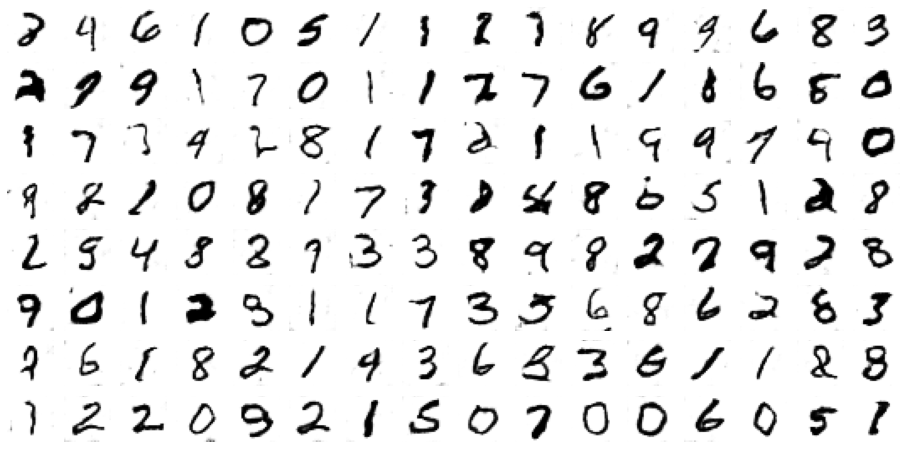

In [5]:
def plotSome():
    S = 8
    X, _ = generate_fake_samples(g_model, latent_dim, n_cat, 2 * S * S)
    plt.subplots(figsize=(2*S, S))
    for i in range(2 * S * S):
        plt.subplot(S, 2 * S, 1 + i)
        plt.axis('off')
        plt.imshow(X[i, :, :, 0], cmap='gray_r')
    plt.show()
plotSome()